In [1]:
import spacy
import pickle
from spacy import displacy
nlp = spacy.load('en_core_web_trf')
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm as tqdm_notebook
import collections
import re
import pandas as pd
import math
import random
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
# Color checker
colors = list(mcolors.CSS4_COLORS.keys())

## Create a glossary list

In [3]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_plant_morphology'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   

glossary = collections.defaultdict(list)
# Find all H4 
for chapter in soup.find_all('h4')[0:]:
    # Clean
    chapter_text = chapter.text.rstrip('[edit]')
    # Find all siblings
    for sibling in chapter.find_next_siblings():
        # Find the parent
        for parent in sibling.find_previous_sibling('h4'):
            # Only append if correspond to current chapter
            if parent.text == chapter_text:
                if 'â' in sibling.text:
                    for tag in sibling.find_all('li'):
                        candidates = tag.text.split('â')[0]
                        candidates = candidates.split('/')
                        for candidate in candidates:
                            glossary[chapter_text.lower()].append(candidate.strip().lower())

In [4]:
glossary.keys()

dict_keys(['morphology', 'roots', 'stems', 'buds', 'leaves', 'basic flower parts', 'inflorescences', 'insertion of floral parts', 'union of flower parts', 'flower sexuality and presence of floral parts', 'flower symmetry', 'terms for fruits', 'fruit types', 'pteridophytes', 'bryophytes'])

In [5]:
#glossary['fruit types'] += [
#    'fruit',
#]

glossary['leaves'] += [
    'glume',
    'surface',
    'margin'
]

glossary['basic flower parts'] +=[
    'floret',
    'awn',
    
]
glossary['inflorescences'] += [
    'spikelets',
    'lemma',
    'racemes',
    'axis',
]
glossary['leaves'] += [
    'rhachilla'
]

glossary['other'] += [
    'apex',
    'culm',
    'tube',
    'palea',
    'crown',
    'canopy',

]

### Load the data

In [6]:
AGRO_dirty = pickle.load(open('../data/description/descriptions_agroforestry_PLANTS.pkl', 'rb'))
AGRO = collections.defaultdict(list)
for species in AGRO_dirty.keys():
    for (sentence, URL) in AGRO_dirty[species]:
        AGRO[species].append(sentence)
        
POWO_dirty = pickle.load(open('../data/description/descriptions_powo_PLANTS.pkl', 'rb'))
POWO = collections.defaultdict(list)
for species in POWO_dirty.keys():
    for (sentence, URL) in POWO_dirty[species]:
        POWO[species].append(sentence)
        
LIFE_dirty = pickle.load(open('../data/description/descriptions_llifeV2_PLANTS.pkl', 'rb'))
LIFE = collections.defaultdict(list)
for species in LIFE_dirty.keys():
    for (sentence, URL) in LIFE_dirty[species]:
        LIFE[species].append(sentence)

In [7]:
POWO_species = list(POWO.keys())
AGRO_species = list(AGRO.keys())
LIFE_species = list(LIFE.keys())

# Test set
TEST_species = LIFE_species + AGRO_species
# Common_species
COMMON_species = list(set(POWO_species) & set(TEST_species))

TEST = collections.defaultdict(list)
for species in COMMON_species:
    TEST[species] += AGRO[species]
    TEST[species] += LIFE[species]
    
DATA = pickle.load(open('../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))

In [8]:
descriptions_id = collections.defaultdict(list)
descriptions = collections.defaultdict(list)

compounds = [
    'fertile', 'sterile',
    'male', 'female', 'bisexual',
    'basal', 'developed', 
    'primary', 'secondary', 'main',
    'upper', 'lower', 'greater', 'dorsal', 'alternate', 'lesser', 'apex', 'outer',
    'central', 'outermost', 'outer', 'inner', 'uppermost', 'median', 'dorsal', 'central', 'lateral',
]

def compound_reconstructor(token, doc):
    if token.i == 0:
        trait = token
    elif doc[token.i - 3].dep_ == 'compound':
        trait = doc[token.i - 3: token.i + 1]
    elif doc[token.i - 3].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 3: token.i + 1]
    elif doc[token.i - 2].dep_ == 'compound':
        trait = doc[token.i - 2: token.i + 1]
    elif doc[token.i - 2].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 2: token.i + 1]
    elif doc[token.i - 1].dep_ == 'compound':
        trait = doc[token.i - 1: token.i + 1]
    elif doc[token.i - 1].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 1: token.i + 1]
    else:
        trait = token   
    return trait.lemma_

def check_existance(t, doc):
    single = next((key for key, value in glossary.items() if t.lemma_.lower() in value), None)
    multi = next((key for key, value in glossary.items() if t.text.lower() in value), None)
    if single:
        return single
    elif multi:
        return multi
    else:
        return None

def extract_advmod(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'advmod':
            return child
        
def extract_nummod(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'nummod':
            return child

def extract_conjunction(t, doc):
    """HELPER"""
    if t.dep_ == 'conj' and t.pos_ == 'ADJ':
        return t 

def extract_amod(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'amod':
            return child
        
def extract_measurements(t, doc):
    """HELPER"""
    obj = None
    measurements = ['wide', 'long']
    if t.text in measurements or t.lemma_ in measurements:
        obj = doc[t.left_edge.i : t.right_edge.i + 1]
    return obj

def extract_prepositions(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'prep':
            return doc[child.left_edge.i : child.right_edge.i + 1]

def define_position(x, y, doc):
    """HELPER"""
    if len(x.text.split()) > 1:
        return f'{y.text} {x.text}'
    else:
        try:
            if x.i > y.i:
                return doc[y.i : x.i + 1]
            else:
                return doc[x.i : y.i + 1]
        except:
            return f'{y.text} {x.text}'

def extract_noun_verbs(t, doc):
    relations = []
    objects = []
    if t.dep_ not in ['ROOT', 'nsubj', 'nsubjpass', 'csubj', 'csubjpass']:
        return '', ''
    parent = next((parent for parent in t.ancestors), None)
    if parent and parent.pos_ == 'VERB':
        prep = extract_verb_preps(parent, doc)
        dobj = extract_verb_dobj(parent, doc)
        oprd = extract_verb_orpd(parent, doc)
        agnt = extract_verb_agnt(parent, doc)
        nmod = extract_verb_nmod(parent, doc)
        if prep:
            obj = extract_verb_pobj(prep, doc)
            if obj:
                relations.append(f'{parent.text} {prep}')
                objects.append(obj.lemma_)
        if dobj:
            pass
            #print(dobj)
        if oprd:
            pass
            #print(oprd)
        if agnt:
            pass
           # print(agnt)
        if nmod:
            pass
           # print(nmod)
        grandparent = next((grandparent for grandparent in parent.ancestors), None)
        if not grandparent:
            relations.append('is')
            numbers = extract_nounandverb_nummods(parent, doc)
            if numbers:
                objects.append(f'{numbers.text} {parent.text}')
            else:
                objects.append(parent.text)
    if not parent:
        for child in t.children:
            if child.pos_ == 'VERB' and child.dep_ != 'amod':
                                
                prep = extract_verb_preps(child, doc)
                dobj = extract_verb_dobj(child, doc)
                oprd = extract_verb_orpd(child, doc)
                agnt = extract_verb_agnt(child, doc)
                nmod = extract_verb_nmod(child, doc)
                if prep:
                    noun = extract_verb_pobj(prep, doc)
                    if noun:
                        relations.append(f'{child.text} {prep}')
                    
                        objects.append(doc[noun.left_edge.i : noun.right_edge.i + 1].text)
                if dobj:
                    relations.append(child.text)
                    objects.append(doc[dobj.left_edge.i : dobj.right_edge.i + 1].text)     
                if oprd:
                    oprd_prep = extract_verb_preps(oprd, doc)
                    if oprd_prep:
                        relations.append(f'{child.text} {oprd.text}')
                        objects.append(doc[oprd_prep.left_edge.i : oprd_prep.right_edge.i + 1].text)  
                if agnt:
                    continue
                    #print(agnt)
                if nmod:
                    relations.append('is')
                    objects.append(f'{nmod.text} {child}') 

    rel = []
    obj = []
    for relation, object_ in zip(relations, objects):
        rel.append(relation)
        obj.append(object_.split(',')[0])
            
    return rel, obj

def extract_verb_nmod(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'nummod':
            return doc[child.left_edge.i : child.right_edge.i + 1] 
        
def extract_verb_preps(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'prep':
            return child    

def extract_verb_pobj(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'pobj' or child.dep_ == 'pcomp' or child.dep_ == 'prep':
            return child
        
def extract_verb_dobj(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'dobj':
            return child
        
def extract_verb_orpd(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'oprd':
            return child    
        
def extract_verb_agnt(t, doc):
    """HELPER"""
    for child in t.children:
        if child.dep_ == 'agent':
            return child 
        
def extract_nounandverb_nummods(t, doc):
    obj = None
    for child in t.children:
        if child.dep_ == 'nummod':
            obj = doc[child.left_edge.i : child.right_edge.i + 1]
            return obj   

def extract_dnummod(t, doc):
    obj = extract_nounandverb_nummods(t, doc)
    if obj:
        return obj.text
    else:
        return None

def extract_noun_adjectives(t, doc):
    adjs = []
    adjectives = []
    for child in t.children:
        if child.dep_ == 'appos':
            continue
        if child.pos_ =='ADJ' or child.tag_ == 'VBN' and child.dep_ in ['conj', 'amod']:
            
            
            advmod = extract_advmod(child, doc)
            measurement = extract_measurements(child, doc)
            prep = extract_prepositions(child, doc)
            nummod = extract_nummod(child, doc)
            amod = extract_amod(child, doc)
           
            
            if child.lemma_.lower() in compounds:
                continue
            if child.text.lower() in compounds:
                continue
            elif amod:
                obj = define_position(amod, child, doc)
                adjs.append(obj)
            elif advmod:
                #obj = doc[advmod.i : child.i + 1]
                obj = define_position(advmod, child, doc)
                adjs.append(obj)
            elif measurement:
                obj = measurement
                adjs.append(obj)
            elif prep:
                obj = define_position(prep, child, doc)
                adjs.append(obj)
            elif nummod:
                obj = define_position(nummod, child, doc)
                adjs.append(obj)                
            else:
                obj = child
                adjs.append(obj)
            for grandchild in child.subtree:
                conj = extract_conjunction(grandchild, doc)
                if conj:
                    advmod = extract_advmod(conj, doc)
                    prep = extract_prepositions(conj, doc)
                    nummod = extract_nummod(conj, doc)
                    if advmod:
                        obj = define_position(advmod, conj, doc)
                        adjs.append(obj)
                    elif prep:
                        obj = define_position(prep, conj, doc)
                        adjs.append(obj)
                    elif nummod:
                        obj = define_position(nummod, conj, doc)
                        adjs.append(obj)
                    else:
                        obj = conj
                        adjs.append(obj)            
    for adj in adjs:
        try:
            if adj.pos_ == 'VERB':
                adj_text = adj.text.lower()
            elif adj.root.pos_ == 'VERB':
                adj_text = adj.text.lower()
            else:
                adj_text = adj.lemma_.lower()
        except:
                if type(adj) == str:
                    adj_text = adj.lower()
                else:
                    adj_text = adj.text.lower()
        for adj_split in adj_text.split(','):
            adjectives.append(adj_split.strip())
    return adjectives

def extract_noun_appos(t, doc):
    appos = []
    for child in t.children:
        if child.dep_ == 'appos':
            obj = doc[child.left_edge.i : child.right_edge.i + 1].text.lower()
            for obj_split in obj.split(','):
                appos.append(obj_split.strip())
    return appos

def check_species(t, species, doc):
    if t.text in species.split():
        return True
    else:
        return False
    
def extract_auxillary(t, doc):
     parent = next((parent for parent in t.ancestors if parent.pos_ == 'AUX'), None)
        
        

In [30]:
descriptions = collections.defaultdict(list)

# For plotting purposes
parts = []
traits = []
for species in tqdm_notebook(list(DATA.keys())[50:51]):
    for idx, text in enumerate(DATA[species][0:20]):


#for species in tqdm_notebook(COMMON_species[0:]):
#    for idx, text in enumerate(TEST[species][0:]):
        # Clean the text
        text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)
        text = re.sub(r'\s×\s', ' times ', text)
        text = f'{text.strip()}.'
        # Reset variables
        part=trait=rel=obj=adjectives = None 
        # NLP
        doc = nlp(text)
        # Init
        descriptions[species, idx] = []
        triples = []
        # Loop over tokens
        for t in doc:
            if t.dep_ == 'compound':
                continue
            ### SUBJECTS ###    
            if t.pos_ == 'NOUN' or t.pos_ == 'PROPN':
                # Check existance of parts
                part = check_existance(t, doc)
                if part:
                    # Reconstruct Compounds & Append
                    trait = compound_reconstructor(t, doc)
                    triples.append((species, 'has main part', part))
                    triples.append((part, 'has sub part', trait))

                    
                    # Plotting
                    parts.append(part)
                    traits.append(trait)
                    # NOUN ADJECTIVES
                    adjectives = extract_noun_adjectives(t, doc)
                    for adjective in adjectives:
                        triples.append((trait, 'is', adjective))
                    # NOUN VERBS
                    verbs_rel, verbs_obj = extract_noun_verbs(t, doc)
                    for rel, obj in zip(verbs_rel, verbs_obj):
                        triples.append((trait, rel, obj))
                    # NOUN APPOSITIONAL MODIFIER
                    adjectives = extract_noun_appos(t, doc)
                    for adjective in adjectives:
                        triples.append((trait, 'is', adjective))
                    # NOUN NUMMODS
                    nummod = extract_dnummod(t, doc)
                    triples.append((trait, 'is', nummod))
                
            #if check_species(t, species, doc):

        # APPEND
        descriptions[species, idx] = [triple for triple in triples if all(triple)]     
        
                    
        #print(idx, doc)
        #print(descriptions[species, idx])
        #print('\n')

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
with open('../data/processed/RDF_TRIPLES_TEST_SET_554.pkl', 'wb') as f:
    pickle.dump(descriptions, f)   

In [17]:
descriptions_text = collections.defaultdict(list)

for (species, idx) in descriptions.keys():
    for (sub, rel, obj) in descriptions[(species, idx)]:
        if rel == 'is':
            text = f'{sub} {obj}.'.capitalize()
        else:
            text = f'{sub} {rel} {obj}.'.capitalize()
        descriptions_text[species].append(text)

for species in descriptions_text.keys():
    descriptions_text[species] = list(set(descriptions_text[species]))

In [18]:
with open('../data/processed/RDF_TEXT_TEST_SET_554.pkl', 'wb') as f:
    pickle.dump(descriptions_text, f)   

In [19]:
len(descriptions_text.keys())

224

### Visualizations

In [31]:
RDF_dict_text = collections.defaultdict(list)

source   = []
relation = []
target   = []

for data_list in list(descriptions.values())[0:]:
    for (sub, rel, obj) in data_list:

        source.append(sub)
        relation.append(rel)
        target.append(obj)
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [32]:
def coordinates(angle):
    x = 0.14 * math.sin(math.pi * 2 * angle / 360)
    y = 0.14 * math.cos(math.pi * 2 * angle / 360)
    return np.array([x, y])

baseparts = list(glossary.keys())

In [33]:
nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}

size = 1.5

for node in node_labels:
    if node in list(DATA.keys()):
        node_size[node] = 3.5/size
        node_color[node] = 'darkgreen'
    elif node in parts:
        node_size[node] = 2./size
        node_color[node] = 'green'
    elif node in traits:
        node_size[node] = 1.5/size
        node_color[node] = 'lightgreen'
    else:
        node_size[node] = 1./size
        node_color[node] = 'white'
        

fixed_nodes = {
    'Dichanthelium superatum': np.array([-0.00, -0.00]),
    'fruit types': coordinates(0),
    'stems': coordinates(51),
    'leaves': coordinates(102),

    'inflorescences': coordinates(153),
    'other': coordinates(204),
    'terms for fruits': coordinates(255),
    'basic flower parts': coordinates(306),

}        
        

#pos = nx.spring_layout(G, pos=fixed_nodes, fixed=fixed_nodes, k = 0.023, iterations=100, seed=3, scale=0.4, center=(0,0), dim=2)
pos = nx.spring_layout(G, k = 0.023, iterations=5000, seed=33, dim=2,scale=1, center=(0,0))


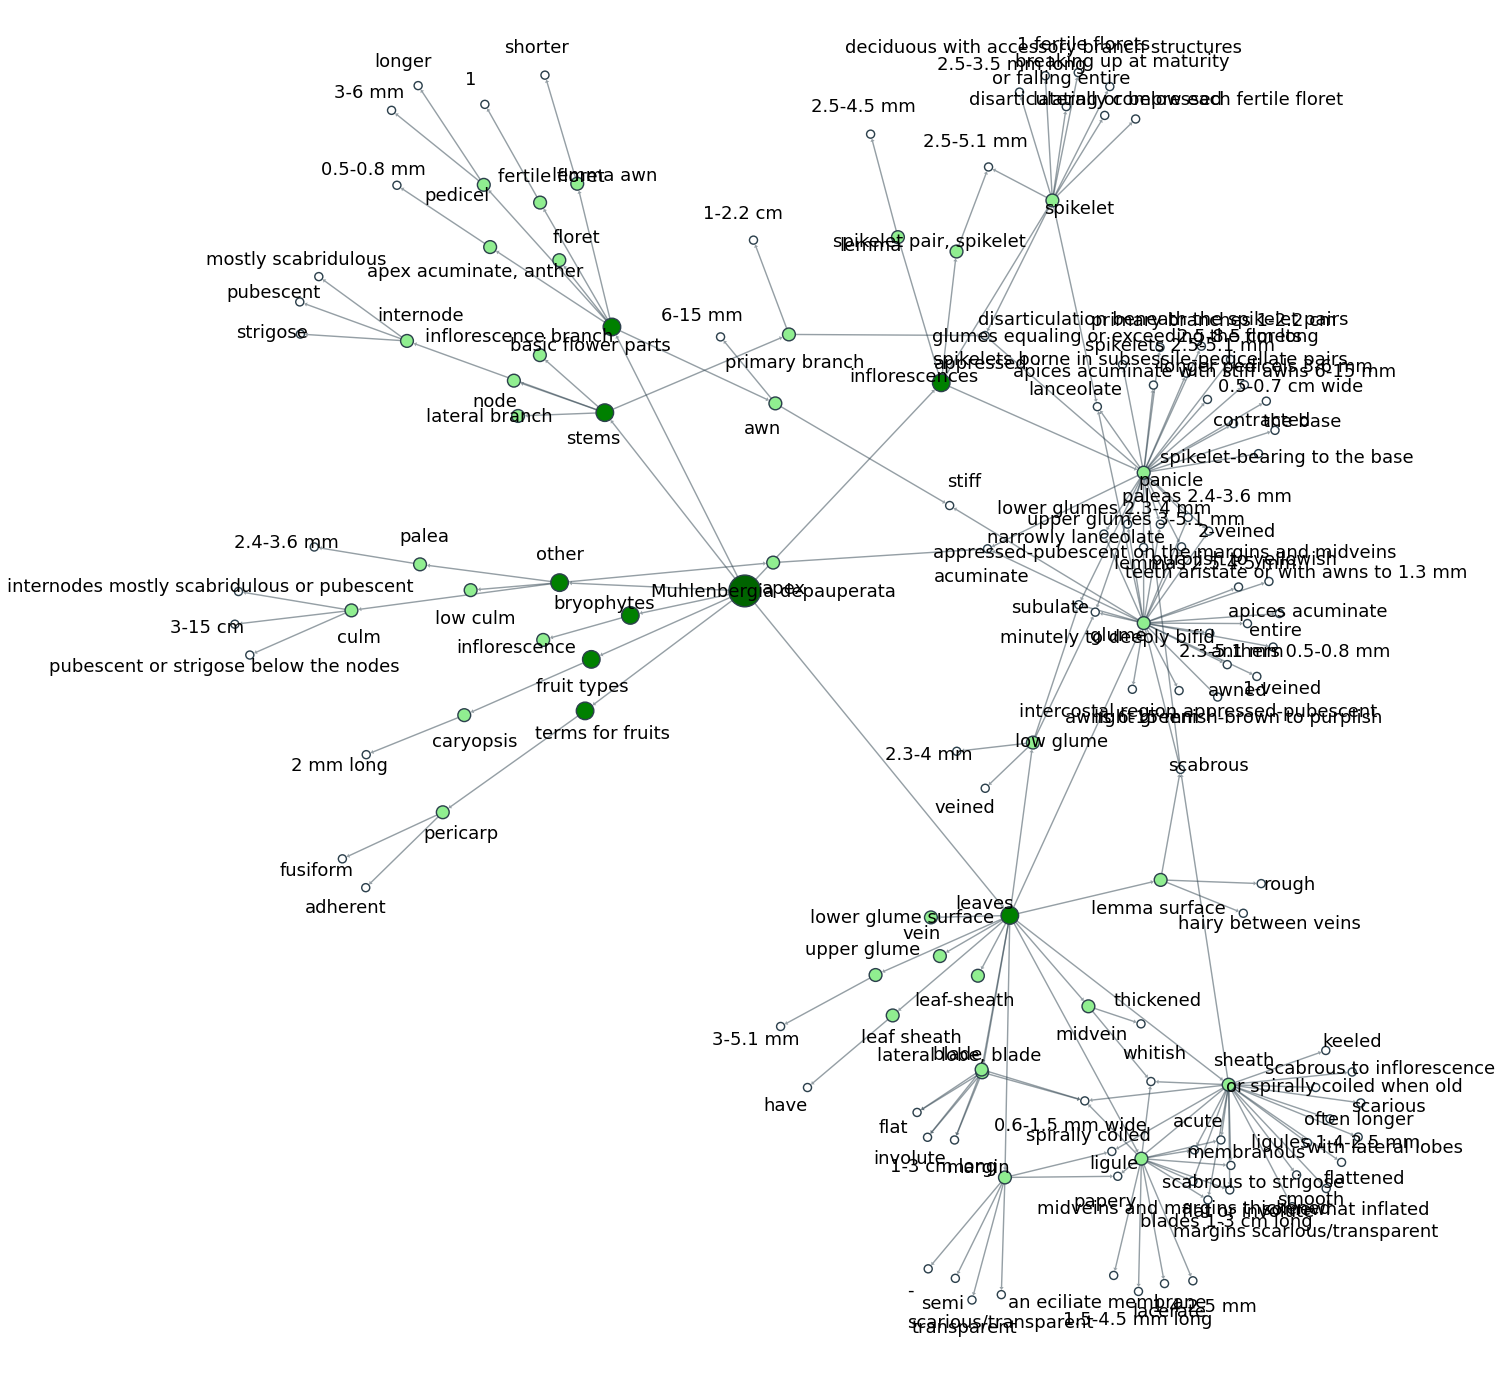

In [34]:
fig, ax = plt.subplots(figsize=(25, 25))
Graph(nodes, 
      #node_layout='spring', edge_layout='curved', 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.04, 
      #edge_labels=edge_labels,
      #node_label_offset=(.00, .04), #node_label_offset=(0.00, -0.035),  
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=5,),
      #node_layout_kwargs=dict(total_iterations=10000, seed=33, k = 0.000005, ),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
      ax=ax)
#plt.savefig('kngraph.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))
Graph(nodes, 
      node_layout='dot', edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      edge_labels=edge_labels,
      node_label_offset=(0.00, -0.04),  
      node_label_fontdict=dict(size=18, rotation=30, ha='right', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.3, edge_label_fontdict=dict(size=5,),
      #node_layout_kwargs=dict(total_iterations=10000, seed=33, k = 0.000005, ),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
      ax=ax)
#plt.savefig('kngraph.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [27]:
RDF_dict_text = collections.defaultdict(list)

source   = []
relation = []
target   = []

for data_list in list(descriptions.values())[0:]:
    for (sub, rel, obj) in data_list:
        
        if rel == 'has main part':
        
            source.append(sub)
            relation.append(rel)
            target.append(obj)
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})


nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}

size = 1.5

for node in node_labels:
    if node in list(DATA.keys()):
        node_size[node] = 3.5/size
        node_color[node] = 'darkgreen'
    elif node in parts:
        node_size[node] = 2./size
        node_color[node] = 'green'
    elif node in traits:
        node_size[node] = 1.5/size
        node_color[node] = 'lightgreen'
    else:
        node_size[node] = 1./size
        node_color[node] = 'white'

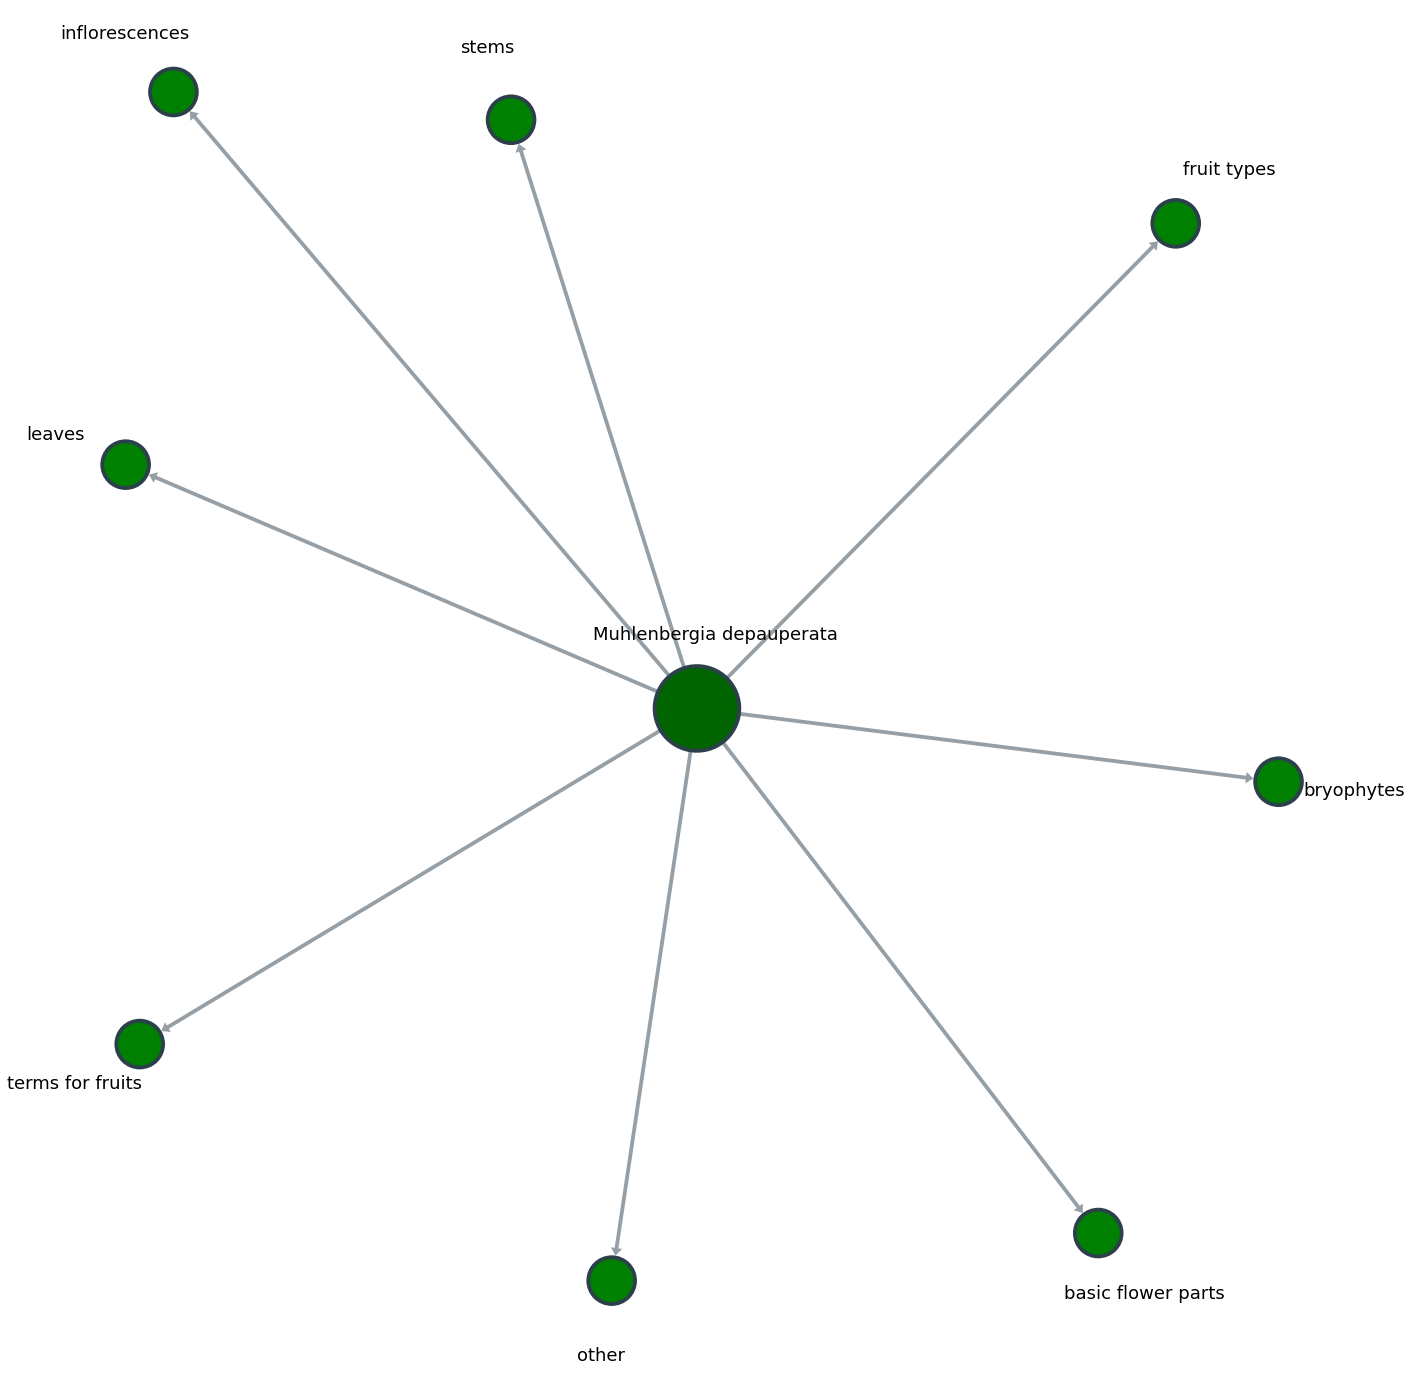

In [29]:
fig, ax = plt.subplots(figsize=(25, 25))
Graph(nodes, 
      #node_layout='spring', edge_layout='curved', 
      node_layout='spring', edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.04, 
      #edge_labels=edge_labels,
      #node_label_offset=(.00, .04), #node_label_offset=(0.00, -0.035),  
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=5,),
      #node_layout_kwargs=dict(total_iterations=10000, seed=33, k = 0.000005, ),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
      ax=ax)


In [35]:
strings = ['the Brown bears have 4 long claws and 2 short ears.',
           'The Brown bear has a brown fur.',
            'The Brown bear has a black nose.',
            'The Brown bear has a large nose.',
            'The Brown bear has a bold belly.',
            'Their feet are orange.',
            'The Brown bear has similar feet as the black bear.',
            'The claws have 5 sharp nails and are 8.5 cm long.',
            'The belly is bold and grey',
            'The nose is black and shiny',
            'It has dark ears',
            'legs muscular with curved nails'
          ]